# Step 1: Business Understanding

### Context
- Company X specially sell their products as a present of the customer in holiday. Many customer of the company are wholesalers.
- Now Company X wants to make more profit in their business and has more customers. In order to do that, they want to know each type of customers and the strategy to approach them.

### Objective
Apply a clustiner algorithm to identify customer in the company. Base one that recommend action for each of them.


### Approach
Using RFM segmentation analysis as a algorithm for clustering customers. Base on that we know who is our VIP, REGULAR, STRANGER, ... customers.


### Prepare environment.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
import squarify
from datetime import datetime
import pandas_profiling as pp
import pickle

#For feature engineering
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

#Evalution model
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer
from collections import Counter
from sklearn.decomposition import PCA

#Statistic test
from pyclustertend import hopkins

def line(sep = '*'):
    print('\n'+sep*20)

#Custom CSS
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.titlesize': 'x-large',
          'figure.figsize': (11, 9),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Step 2: Data Understanding

### Data Context

The data is put in a file name OnlineRetail.csv with total 541.909 records, from 01/12/2010 to 09/12/2011, as online retail invoices.

### Data Content
1. InvoiceNo:  Number of the Invoice, max length is 6, if has "C" in the series, that mean the invoice is cancelled
2. StockCode:  Id of the product
3. Description: Description of the product
4. Quantity: Number of items bought
5. InvoiceDate: The date of the invoice is created.
6. UnitPrice: Price of the product
7. CustomerID: Customer id
8. Country: Customer's country.

# Step 3: Data Preprocessing

Because the data is a litle big, so I applied spark (big data preprocessing) to cleaning the data. You can view the script at the link bellow:
 <a href="https://colab.research.google.com/drive/1As-rLAInFpiT16C0rhlKv1pYBx2gJtcf#scrollTo=C_DPWnjyWMon"> Preprocessing script </a>

After the preprocessing step, we have the clean data at 'RFM_OnlineRetail.csv'

# Step 4: EDA

In [4]:
rfm = pd.read_csv('../data/RFM_OnlineRetail.csv', index_col= 0)
rfm.head()

,customer,recency,frequency,monetary,country
0,12940,54,2,899.69,United Kingdom
1,13285,22,4,2709.12,United Kingdom
2,13623,30,5,727.74,United Kingdom
3,13832,18,1,52.20,United Kingdom
4,14450,180,3,483.25,United Kingdom


In [5]:
rfm.describe()

,customer,recency,frequency,monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,91.536422,4.272015,2048.688084
std,1721.808492,100.014169,7.697998,8985.230341
min,12346.000000,0.000000,1.000000,3.750000
25%,13813.250000,17.000000,1.000000,306.482500
50%,15299.500000,50.000000,2.000000,668.570000
75%,16778.750000,141.000000,5.000000,1660.597500
max,18287.000000,373.000000,209.000000,280206.030000


In [6]:
profile = pp.ProfileReport(rfm)
profile

Summarize dataset: 19it [00:06,  2.98it/s, Completed]                                            
Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


From the report we can see:
- There are many customers ordered recently: recency in range [0,9] take 58.5% of total records.
- The customers who ordered only once take 34.4% of total customers. 
- The average spend on the customers is 2048, while the meadian one is 668 and the std = 8985 => There are a big gap in distribution of spending in our customers.
- More than 90.4% customer are domestic (United Kingdom). 9.6% left are live in foreign country (36 countries in total). Germany, France are the top two foreign countries which have most customers. (Germany: 2.2%, France: 2.0%)



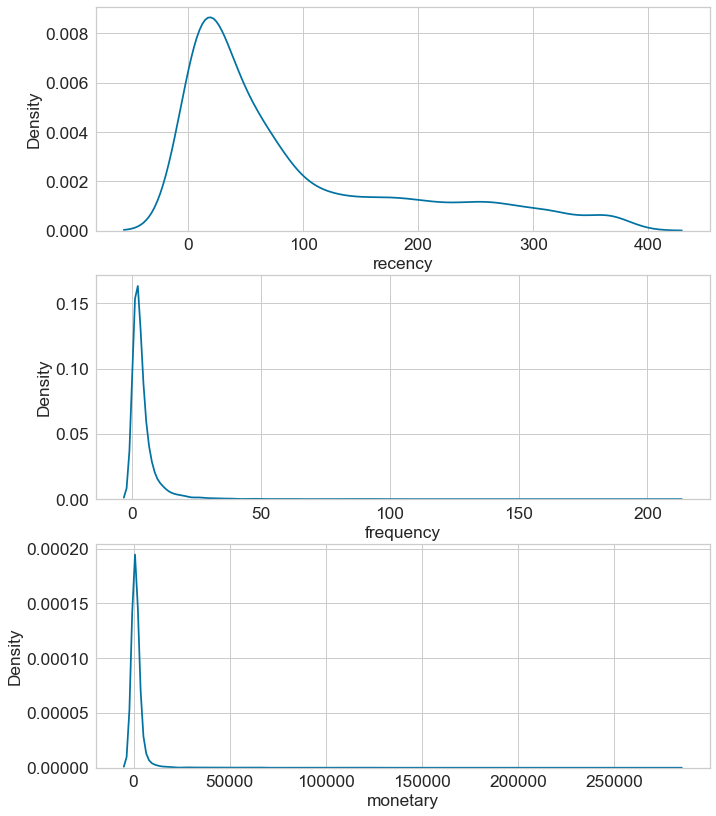

In [7]:
#See their distribution
f, ax = plt.subplots(3, 1, figsize=(11,14))
sns.kdeplot(rfm['recency'], ax = ax[0])
sns.kdeplot(rfm['frequency'], ax = ax[1])
sns.kdeplot(rfm['monetary'], ax = ax[2])
plt.show()


From the second and third graphs, we can see most of customers are in low activity region.
And the first graph show us, most of customer are the new ones.

In [8]:
#Cut them into groups
r_labels = range(4, 0, -1)
f_labels = range(1,5)
m_labels = range(1, 5)
#Using qbin, we divide them into 4 group by their quantities, and set their lable from 1-4 (base on rating) 1 is worst and 4 is best
rfm.loc[:, 'R'] = pd.qcut(rfm.recency.rank(method='first'), q = 4, labels=r_labels)
rfm.loc[:, 'F'] = pd.qcut(rfm.frequency.rank(method='first'), q = 4, labels=f_labels)
rfm.loc[:, 'M'] = pd.qcut(rfm.monetary.rank(method='first'), q = 4, labels=m_labels)

rfm.head()

,customer,recency,frequency,monetary,country,R,F,M
0,12940,54,2,899.69,United Kingdom,2,2,3
1,13285,22,4,2709.12,United Kingdom,3,3,4
2,13623,30,5,727.74,United Kingdom,3,3,3
3,13832,18,1,52.20,United Kingdom,3,1,1
4,14450,180,3,483.25,United Kingdom,1,3,2


In [9]:
#How much group are there
def concat(row):
    return str(row['R']) + str(row['F']) + str(row['M'])
rfm.loc[:, 'group'] = rfm.apply(lambda x: concat(x), axis = 1)
print(f'There are total {len(rfm["group"].unique())} groups')
rfm.head()

There are total 62 groups


,customer,recency,frequency,monetary,country,R,F,M,group
0,12940,54,2,899.69,United Kingdom,2,2,3,223
1,13285,22,4,2709.12,United Kingdom,3,3,4,334
2,13623,30,5,727.74,United Kingdom,3,3,3,333
3,13832,18,1,52.20,United Kingdom,3,1,1,311
4,14450,180,3,483.25,United Kingdom,1,3,2,132


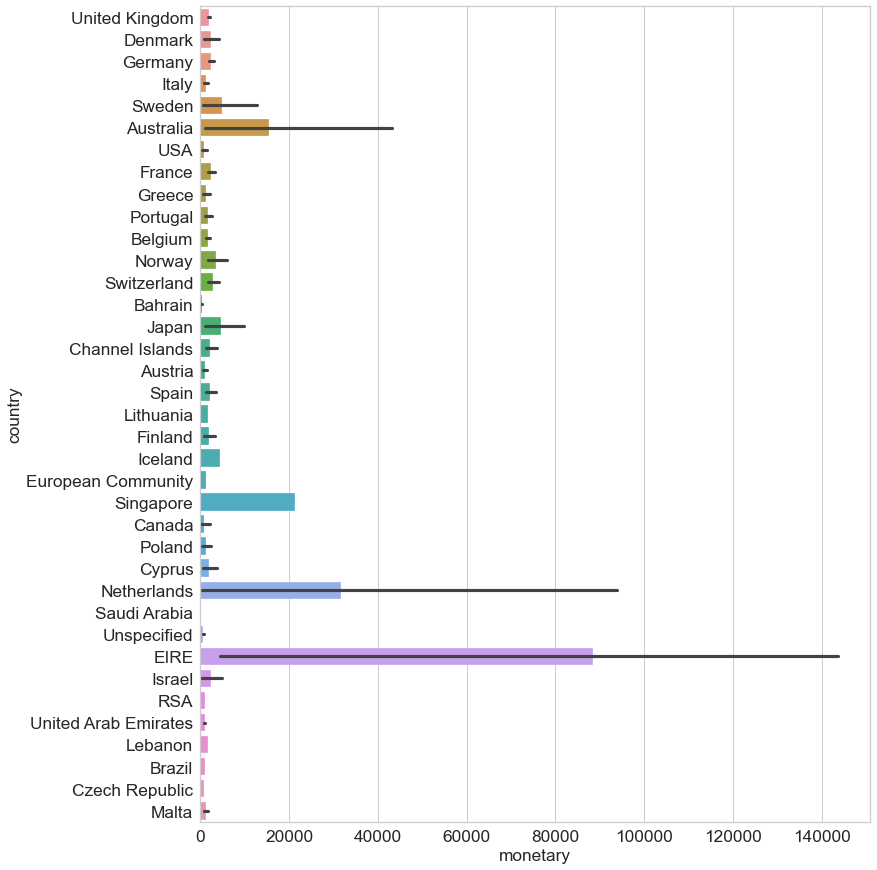

In [10]:
plt.figure(figsize=(12,15))
sns.barplot(data = rfm, y = 'country', x = 'monetary');

Ireland (EIRE), Netherlands, Australia are the top 3 country which have best selling on average.

In [11]:
px.box(rfm, x='recency').show()
px.box(rfm, x='monetary').show()
px.box(rfm, x='frequency').show()



A lot of outliers => use log transform to balance data.

On the other hand, from the first graph, there are a group of customers had gone. Their recency (the last day active) was almost a year ago.

In [12]:
data = rfm[['recency', 'frequency', 'monetary']]
#Log transform
data.loc[:, 'recency'] = np.log1p(data['recency'])
data.loc[:, 'frequency'] = np.log1p(data['frequency'])
data.loc[:, 'monetary'] = np.log1p(data['monetary'])


C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



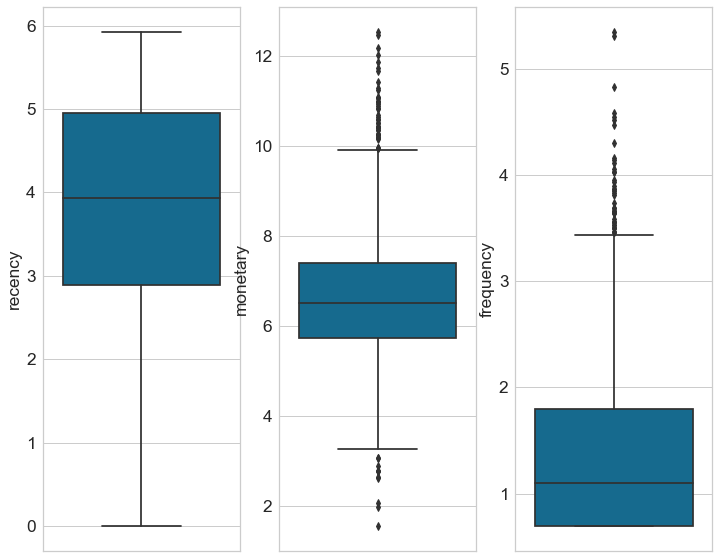

In [13]:
f, ax = plt.subplots(1,3, figsize = (12, 10))
sns.boxplot(y = data['recency'], ax = ax[0])
sns.boxplot(y = data['monetary'], ax = ax[1])
sns.boxplot(y = data['frequency'], ax = ax[2])
plt.show()

All features do not have normalized distribution, and have outliers => Use RobustScaler to scale data.

In [14]:
#Scaling data
scaler = RobustScaler()
data.loc[:,['recency', 'frequency', 'monetary']] = scaler.fit_transform(data)
data.describe()

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,recency,frequency,monetary
count,4338.000000,4338.000000,4.338000e+03
mean,-0.079543,0.224802,4.856011e-02
std,0.693525,0.621788,7.459105e-01
min,-1.903612,-0.369070,-2.933106e+00
25%,-0.504225,-0.369070,-4.612708e-01
50%,0.000000,0.000000,-2.632240e-16
75%,0.495775,0.630930,5.387292e-01
max,0.964645,3.867147,3.578086e+00


## Hopkins test
Before clustering, there are a statistic measure can measure the cluster tendency of a data:

Hopkins test:  It belongs to the family of sparse sampling tests. It acts as a statistical hypothesis test where the null hypothesis is that the data is generated by a Poisson point process and are thus uniformly randomly distributed.
 + A value close to 1 tends to indicate the data is highly clustered
 + Random data will tend to result in values around 0.5
 + Uniformly distributed data will tend to result in values close to 0

Also hopkins test is very sensitive to outliers, so make sure to scale the data first before apply hopkins test.

In [15]:
data.shape

(4338, 3)

In [16]:
hopkins(data, data.shape[0])

0.05713780813793675



Recently, hopkins test was proposed to change the output result to: `1 -H` with H is the value of statistic. So, now in reverse, the value of hopkins statistic is closer to zero, is meaningful to clustering. 


# Step 5: Modeling

# DBSCAN

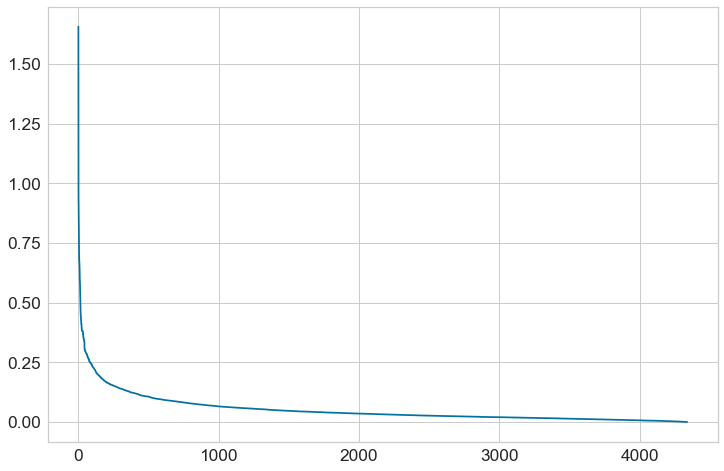

In [17]:
#Run breath search for finding best parameters
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10, n_jobs=-1).fit(data)
distances, indices = neighbors.kneighbors(data)
distances = np.sort(distances, axis = 0)[::-1]

#Plot the elbow line
plt.figure(figsize=(12,8))
distances_draw = distances[:,1]
plt.plot(distances_draw)
plt.show()

Look at the elbow, esp=0.2 is giving the best result.

In [18]:
dbscan = DBSCAN(eps=0.2, min_samples=30).fit(data)
print(Counter(dbscan.labels_))
silhouette_score(data, dbscan.labels_)

Counter({-1: 1389, 1: 1334, 0: 650, 3: 628, 2: 337})


0.006061194385389012

The silhouette score is very low, maybe this algorithm is not working well with this data.

## KMeans

In [19]:
report = pd.DataFrame(columns = ['K', 'Silhouette Score', 'SSE'])
row = 0

for k in range(2,20):
    t = KMeans(n_clusters=k, random_state = 0)
    t.fit(data)
    report.loc[row, 'K'] = k
    report.loc[row, 'Silhouette Score'] = silhouette_score(data, t.labels_)
    report.loc[row, 'SSE'] = t.inertia_
    row+=1

report

,K,Silhouette Score,SSE
0,2,0.428887,3110.841516
1,3,0.332427,2355.169113
2,4,0.334291,1910.82643
3,5,0.312491,1621.796614
4,6,0.308835,1390.274204
5,7,0.305373,1246.398649
6,8,0.289197,1141.867682
7,9,0.281502,1046.235808
8,10,0.281526,968.127282
9,11,0.276045,905.397651


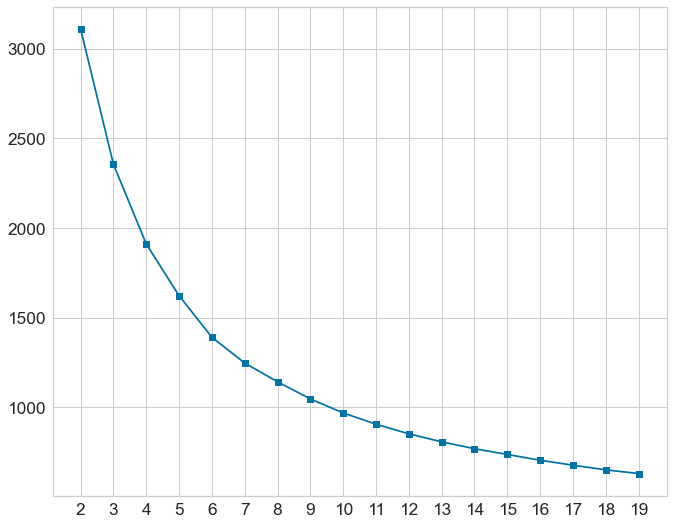

In [20]:
plt.plot(report['K'], report['SSE'], 'bs-')
plt.xticks(range(2,20))
plt.show()

Base on the elbow method the best score is at five. I choose five not six because this smaller cluster the better, in my experience.

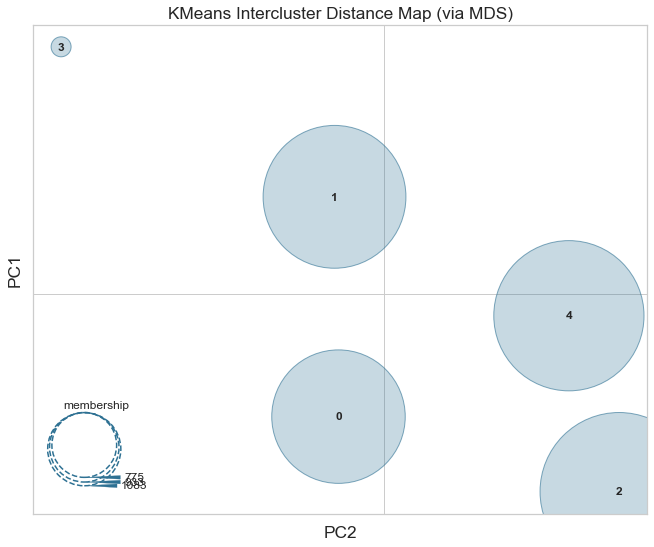

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [21]:
kmean = KMeans(n_clusters=5, random_state=0)
visualizer = InterclusterDistance(kmean, random_state=0, legend_loc='lower left')
visualizer.fit(data)
visualizer.show()

We can see Kmean with cluster 4 is a best idea for this dataset.

Next we try with Gaussian Mixture to know if there are a better results.

## Gaussian Mixture

In [22]:
report = pd.DataFrame(columns = ['K', 'Silhouette Score', 'SSE'])
row = 0

for k in range(2,15):
    t = GaussianMixture(n_components=k, random_state = 0)
    t.fit(data)
    labels = t.predict(data)
    report.loc[row, 'K'] = k
    report.loc[row, 'Silhouette Score'] = silhouette_score(data, labels)
    row+=1

report

,K,Silhouette Score,SSE
0,2,0.276103,NaN
1,3,0.243576,NaN
2,4,0.164553,NaN
3,5,0.145631,NaN
4,6,0.145226,NaN
5,7,0.144384,NaN
6,8,0.083562,NaN
7,9,0.083108,NaN
8,10,0.089735,NaN
9,11,0.043433,NaN


The report suggests five cluster is the best. But look at the silhouette_score on average it not as good as Kmean. 

So in finally I will use Kmean for this dataset.

# Step 6: Make a report

In [23]:
kmean = KMeans(n_clusters=5, random_state=0).fit(data)
pred_data = rfm.copy()
pred_data['cluster'] = kmean.labels_

In [24]:
overall = pred_data.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}).round(2)

overall.columns = overall.columns.droplevel()
overall.columns = ['Recency Mean','Frequency Mean','Monetary Mean', 'Count']
overall['Percent'] = round((overall['Count']/overall.Count.sum())*100, 2)

# Reset the index
overall = overall.reset_index()
overall

,cluster,Recency Mean,Frequency Mean,Monetary Mean,Count,Percent
0,0,19.32,1.92,449.83,775,17.87
1,1,21.70,6.55,2653.13,933,21.51
2,2,193.38,1.22,253.78,1269,29.25
3,3,6.47,22.50,15821.61,278,6.41
4,4,105.88,2.90,1239.86,1083,24.97


From the above statistic table, we can explain each custer like this:
+ Cluster 0: They are the new one, number of orders on average 1.92 (times), they active recently (19.32 days) on average.
+ Cluster 1: Prospective, look at the frequency and monetary, it show us that they have a tendency of buying many products in a short time.
+ Cluster 2: They are gone or left, their last day active was six month ago (on average). They take 29.25% of total customers.
+ Cluster 3: The HOT one, they are spending frequently, largely, and active recently.
+ Cluster 4: The old customer are likely gone. Their last day active was two-three month ago (on average), take 25% of total customers.


In [25]:
#Labeling clusters
labels = {
    2: 'GONE',
    4: 'LIKELY GONE',
    3: 'HOT',
    1: 'PROSPECTIVE',
    0: 'NEW'
}
pred_data['labels'] = pred_data['cluster'].map(labels)
pred_data.head()

,customer,recency,frequency,monetary,country,R,F,M,group,cluster,labels
0,12940,54,2,899.69,United Kingdom,2,2,3,223,4,LIKELY GONE
1,13285,22,4,2709.12,United Kingdom,3,3,4,334,1,PROSPECTIVE
2,13623,30,5,727.74,United Kingdom,3,3,3,333,4,LIKELY GONE
3,13832,18,1,52.20,United Kingdom,3,1,1,311,0,NEW
4,14450,180,3,483.25,United Kingdom,1,3,2,132,4,LIKELY GONE


In [26]:
#Create a report again
overall = pred_data.groupby('labels').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}).round(2)

overall.columns = overall.columns.droplevel()
overall.columns = ['Recency Mean','Frequency Mean','Monetary Mean', 'Count']
overall['Percent'] = round((overall['Count']/overall.Count.sum())*100, 2)

# Reset the index
overall = overall.reset_index()
overall

,labels,Recency Mean,Frequency Mean,Monetary Mean,Count,Percent
0,GONE,193.38,1.22,253.78,1269,29.25
1,HOT,6.47,22.50,15821.61,278,6.41
2,LIKELY GONE,105.88,2.90,1239.86,1083,24.97
3,NEW,19.32,1.92,449.83,775,17.87
4,PROSPECTIVE,21.70,6.55,2653.13,933,21.51


In [31]:
fig = px.scatter(overall, x="Recency Mean", size="Monetary Mean",  y="Frequency Mean", color="labels",
                 hover_name="labels", size_max=150, height=650, log_x=True, width=1000)

fig.write_html('../visulazation_graph/report.html')
fig.show()

In [32]:
final_report = pd.DataFrame(index = overall.labels, columns=['Recomendation Action'])

final_report.loc['GONE', 'Recomendation Action'] = 'The best thing to do with this customer is do nothing. Because when they have intension to leave, it will very hard to pull they back. On the other side, if we can pull them back, the best result we can do is turn them into the LIKELY GONE customer or the New one. So the better if we save the monney and resource for the other customers.' 

final_report.loc['HOT', 'Recomendation Action'] = 'They are the customer we have to priorities to please them with every thing we can do. Do the research of what they like about the company, and listen to what they do not like. From that we can change and update our service to be better.'

final_report.loc['LIKELY GONE', 'Recomendation Action'] = 'They are the old customers who are likely gone, we can do a survey to know what they think and feel about bussiness. Maybe there opinions can help us improve out service.'

final_report.loc['NEW', 'Recomendation Action'] = 'They are new customers who came to us recently. Lets try to do our best, as we did with the HOT customers. To see if we can have more loyal one. We can open some discount to attract them'

final_report.loc['PROSPECTIVE', 'Recomendation Action'] = 'The top 2 customer we need to care as much as we can. They are regular one, they come to use our service but not much, we they are using long enough. Maybe we can do a survey on them to know what they really think, before do any action. '

from IPython.display import HTML
HTML(final_report.to_html())


,Recomendation Action
labels,
GONE,"The best thing to do with this customer is do nothing. Because when they have intension to leave, it will very hard to pull they back. On the other side, if we can pull them back, the best result we can do is turn them into the LIKELY GONE customer or the New one. So the better if we save the monney and resource for the other customers."
HOT,"They are the customer we have to priorities to please them with every thing we can do. Do the research of what they like about the company, and listen to what they do not like. From that we can change and update our service to be better."
LIKELY GONE,"They are the old customers who are likely gone, we can do a survey to know what they think and feel about bussiness. Maybe there opinions can help us improve out service."
NEW,"They are new customers who came to us recently. Lets try to do our best, as we did with the HOT customers. To see if we can have more loyal one. We can open some discount to attract them"
PROSPECTIVE,"The top 2 customer we need to care as much as we can. They are regular one, they come to use our service but not much, we they are using long enough. Maybe we can do a survey on them to know what they really think, before do any action."


Có thể thấy có sự phân biệt rõ rệt trong cách tiêu dùng giữa khách hàng nóng và các loại khách hàng khác.
Kích cỡ của hình tròn cũng tượng trưng cho kích cỡ của các mỏ vàng mà doanh nghiệp có thể khai thác.
Do đó chúng ta nên tập trung vào 3 loại khách hàng chính là NEW, HOT, VÀ PROSPECTIVE (khách hàng tiềm năng)

In [33]:
#Save data for later use
pred_data.to_csv("../data/CustomerLabels.csv", index = False)
overall.to_csv("../data/ReportCustomerLabels.csv",index = False)
final_report.to_csv("../data/strategy.csv")